In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from PIL import Image
from numpy import asarray

In [63]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "datasets"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 988 files belonging to 5 classes.
Using 791 files for training.
Found 988 files belonging to 5 classes.
Using 197 files for validation.


In [22]:
class_names = train_dataset.class_names
print(class_names)

['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']


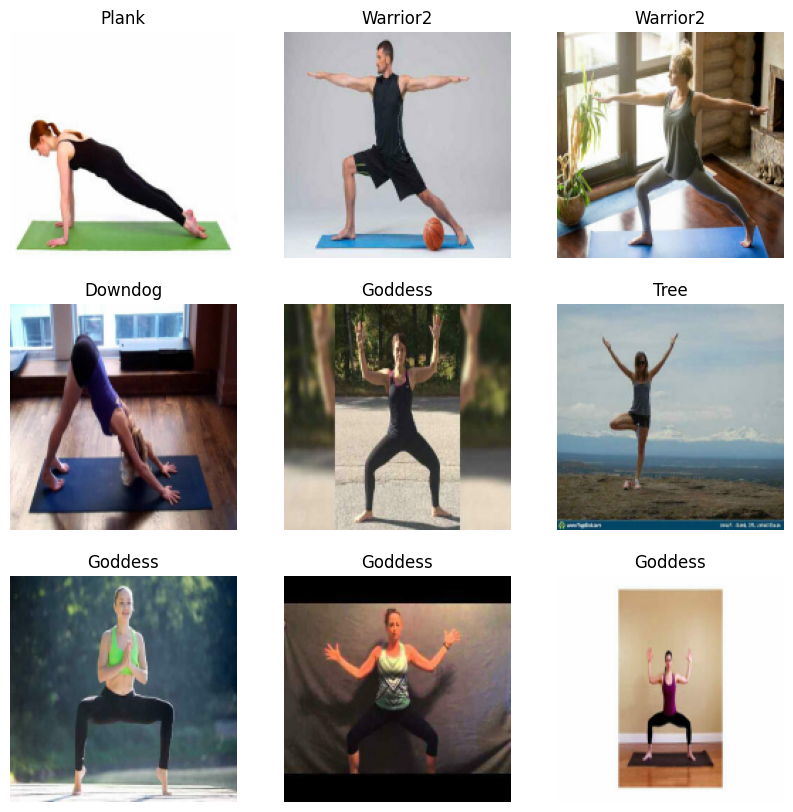

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

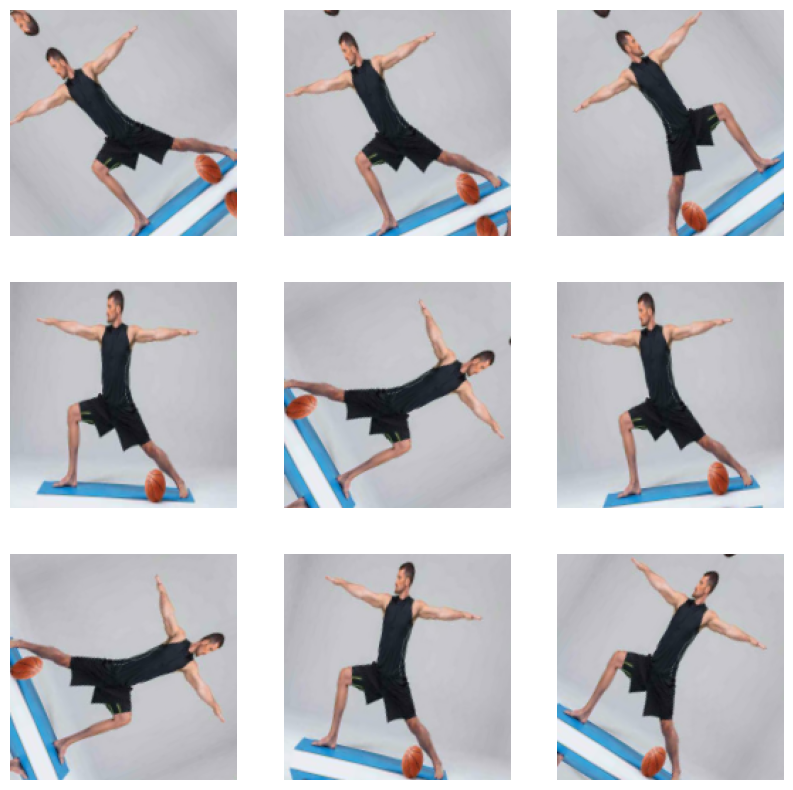

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [39]:
def model(image_shape=IMG_SIZE, base_model=base_model):

    input_shape = image_shape + (3,)
    #base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
    #                                               include_top=False,
    #                                               weights='imagenet')
    base_model.trainable = False    # freeze base model by making it non trainable
    inputs = tf.keras.Input(shape=input_shape) # create input layer (Same as imageNetv2 input size)
    x = data_augmentation(inputs) # apply data augmentation to the inputs
    x = preprocess_input(x) # data preprocessing using the same weights the model was trained
    x = base_model(x, training=False) # set training to False
    x = tfl.GlobalAveragePooling2D()(x) # use global avg pooling to summarize the info in each channel
    x = tfl.Dropout(0.2)(x)  # include dropout with probability of 0.2 to avoid overfitting
    outputs = tfl.Dense(units=5, activation='softmax')(x) #use a prediction layer with 'softmax' classification
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [40]:
model = model(IMG_SIZE, base_model)
base_learning_rate = 0.01 # Changing the learning rate drastically slows down training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [41]:
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
25/25 [==============================] - 10s 295ms/step - loss: 1.3031 - accuracy: 0.5777 - val_loss: 0.4930 - val_accuracy: 0.8376
Epoch 2/5
25/25 [==============================] - 9s 338ms/step - loss: 0.5317 - accuracy: 0.8142 - val_loss: 0.3540 - val_accuracy: 0.8528
Epoch 3/5
25/25 [==============================] - 8s 321ms/step - loss: 0.3358 - accuracy: 0.8862 - val_loss: 0.2588 - val_accuracy: 0.9036
Epoch 4/5
25/25 [==============================] - 10s 384ms/step - loss: 0.3433 - accuracy: 0.8812 - val_loss: 0.5319 - val_accuracy: 0.8122
Epoch 5/5
25/25 [==============================] - 11s 436ms/step - loss: 0.2879 - accuracy: 0.8875 - val_loss: 0.3859 - val_accuracy: 0.8934


In [ ]:
model.predict()

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 6s 202ms/step - loss: 1.8827 - accuracy: 0.1980


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
25/25 [==============================] - 11s 240ms/step - loss: 0.4919 - accuracy: 0.1593 - val_loss: 0.0854 - val_accuracy: 0.1523
Epoch 2/10
25/25 [==============================] - 8s 329ms/step - loss: -1.0860 - accuracy: 0.1808 - val_loss: -1.3173 - val_accuracy: 0.1827
Epoch 3/10
25/25 [==============================] - 8s 324ms/step - loss: -2.4775 - accuracy: 0.1947 - val_loss: -2.4630 - val_accuracy: 0.1878
Epoch 4/10
25/25 [==============================] - 12s 494ms/step - loss: -3.7969 - accuracy: 0.2023 - val_loss: -3.5300 - val_accuracy: 0.1878
Epoch 5/10
25/25 [==============================] - 11s 418ms/step - loss: -4.9345 - accuracy: 0.2048 - val_loss: -4.5477 - val_accuracy: 0.1878
Epoch 6/10
25/25 [==============================] - 9s 377ms/step - loss: -5.9685 - accuracy: 0.2048 - val_loss: -5.5534 - val_accuracy: 0.1878
Epoch 7/10
25/25 [==============================] - 15s 613ms/step - loss: -7.3147 - accuracy: 0.2048 - val_loss: -6.5788 - val_accurac

In [59]:
image = Image.open('datasets/Downdog/00000000.jpg').resize((160, 160))

In [60]:
numpydata = asarray(image)

In [66]:
[class_names[np.argmax(i)] for i in model.predict(train_dataset)]

25/25 [==============================] - 4s 162ms/step


['Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Downdog',
 'Do